# Diffusion as a Stochastic Process

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [43]:
X = np.zeros((102,102))

In [44]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [45]:
X.shape

(102, 102)

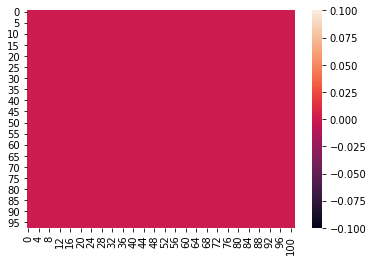

In [46]:
sns.heatmap(X[1:100][1:100])

In [47]:
for i in range(400):
    i,j = np.random.randint(1,101), np.random.randint(1,101)
    X[i][j] = X[i][j] + 1

In [48]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

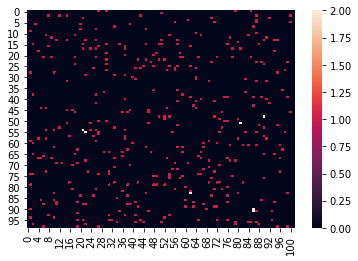

In [49]:
sns.heatmap(X[1:101][1:101])

### Actualización de Condiciones Periódicas

In [50]:
for j in range(1,101):
    X[0][j] = X[100][j]
    X[101][j] = X[1][j]
    X[j][0] = X[j][100]
    X[j][101] = X[j][1]

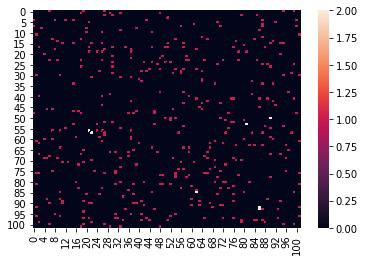

In [52]:
sns.heatmap(X[:][:])

### Ley de Fick

El flujo de partículas es proporcional al gradiente de concentración

$$J(\mathbf{x},t) = - D \nabla c(\mathbf{x}, t)$$

Número de partículas que cruzan, por unidad de área, por unidad de tiempo. Entonces $A J$ es el número de partículas por unidad de tiempo que están atravesando la "ventana" de tamaño $A$.

Para implementar el algoritmo, debemos calcular la probabilidades por unidad de tiempo de moverse las partículas a regiones contiguas. Para ello, usamos una versión discreta de la ley de Fick

$$a(s,d,i,j) =  - A D \frac{\left [X(s,i + 1,j)/L^3 - X(s, i,j)/L^3 \right ]}{L}$$

$$[D] = \frac{L^2}{s}$$

en donde $d$ indica la dirección en la que se movería la partícula, en este caso a la derecha; cada partícula tiene 4 grados de libertad. Esto es, aquí la clave de poder considerar la difusión como un procesos análogo a las reacciones químicas (desde el punto de vista probabilístico), es que cada posibilidad de movimiento es análogo o equivalente a la posibilidad de una transmutación química.


En un espacio de dos dimensiones, hay 4 posibilidades para cada molécula o partícula; hay que ponderarlas todas

In [63]:
D = 1

In [70]:
a = np.zeros((4,101,101))

### Cálculo de las "propensiones" $a(s,d,i,j)$

In [71]:
for i in range(1,101):
    for j in range(1,101):
        a[0][i][j] = D*(X[i][j] - X[i - 1][j])
        if a[0][i][j] < 0:
            a[0][i][j] = 0
        a[1][i][j] = D*(X[i][j] - X[i + 1][j])
        if a[1][i][j] < 0:
            a[1][i][j] = 0
        a[2][i][j] = D*(X[i][j] - X[i][j - 1])
        if a[2][i][j] < 0:
            a[2][i][j] = 0
        a[3][i][j] = D*(X[i][j] - X[i - 1][j + 1])
        if a[3][i][j] < 0:
            a[3][i][j] = 0

In [65]:
a[0][1][1] = D*(X[1][1] - X[1 - 1][1])

In [66]:
a[1][1][1] = D*(X[1][1] - X[1 + 1][1])

In [67]:
a[2][1][1] = D*(X[1][1] - X[1][1 - 1])

In [68]:
a[3][1][1] = D*(X[1][1] - X[1 - 1][j + 1])

In [69]:
a[0][100][100] = D*(X[100][100] - X[100 - 1][1])

IndexError: index 100 is out of bounds for axis 0 with size 100

In [74]:
def actualizacion_as(a, X):
    for i in range(1,101):
        for j in range(1,101):
            a[0][i][j] = D*(X[i][j] - X[i - 1][j])
            if a[0][i][j] < 0:
                a[0][i][j] = 0
            a[1][i][j] = D*(X[i][j] - X[i + 1][j])
            if a[1][i][j] < 0:
                a[1][i][j] = 0
            a[2][i][j] = D*(X[i][j] - X[i][j - 1])
            if a[2][i][j] < 0:
                a[2][i][j] = 0
            a[3][i][j] = D*(X[i][j] - X[i - 1][j + 1])
            if a[3][i][j] < 0:
                a[3][i][j] = 0
        return a

### Rutina Montecarlo

$$P(\tau, \mu, i, j) = a(\mu, i, j)\, \exp{-[\sum_{\mu i j} a(\mu, i ,j)] \tau ]}$$

$$P(\tau, \mu, i, j) = P_1(\tau) P_2(\mu, i, j| \tau)$$

$$P_1(\tau)= \exp{-[\sum_{\mu i j} a(\mu, i ,j)] \tau ]}  \sum_{\mu i j} a(\mu, i, j)$$

$$P_2(\mu, i, j| \tau) = \frac{a( \mu, i, j)}{\sum_{\mu i j} a(\mu, i, j)}$$

$$P_3(\mu |\tau) = \sum_{i j} P_2(\mu, i, j | \tau)$$


$$P_4(\mu, i |\tau) = \sum_{j} P_2(\mu,i,j|\tau) = \sum_{j} \left [\frac{a(\mu,i,j)}{\sum_{\mu, i, j} a(\mu,i,j)}   \right ]$$

$$P_5(\mu, j | \tau) = \sum_{i} P_2(\mu,i,j|\tau) = \sum_{j} \left [\frac{a(\mu,i,j)}{\sum_{\mu, i, j} a(\mu,i,j)}   \right ]$$

In [88]:
P2 = np.zeros((4,101,101))
P3 = np.zeros((4))
P4 = np.zeros((4,101))
P5 = np.zeros((4,101))

In [89]:
a0 = 0
for d in range(0,4):
        for i in range(1,101):
            for j in range(1,101):
                a0 = a0 + a[d][i][j]

In [90]:
a0

1542.0

In [91]:
for mu in range(4):
    for i in range(1,101):
        for j in range(1,101):
            P2[mu][i][j] = a[d][i][j]/a0

In [92]:
for mu in range(4):
    suma_mu = 0
    for i in range(1,101):
        for j in range(1,101):
            suma_mu = suma_mu + P2[mu][i][j]
    P3[mu] = suma_mu

In [96]:
for mu in range(4):
    for i in range(1,101):
        suma_j = 0
        for j in range(1,101):
            suma_j = suma_j + P2[mu,i,j]
        P4[mu][i] = suma_j

In [97]:
for mu in range(4):
    for j in range(1,101):
        suma_i = 0
        for i in range(1,101):
            suma_i = suma_i + P2[mu,i,j]
        P5[mu][j] = suma_i

### Función que actualiza las probabilidades

In [98]:
def act_probs(a,P2,P3,P4,P5):
    a0 = 0
    for d in range(0,4):
            for i in range(1,101):
                for j in range(1,101):
                    a0 = a0 + a[d][i][j]
    for mu in range(4):
        for i in range(1,101):
            for j in range(1,101):
                P2[mu][i][j] = a[d][i][j]/a0
    for mu in range(4):
        suma_mu = 0
        for i in range(1,101):
            for j in range(1,101):
                suma_mu = suma_mu + P2[mu][i][j]
        P3[mu] = suma_mu
    for mu in range(4):
        for i in range(1,101):
            suma_j = 0
            for j in range(1,101):
                suma_j = suma_j + P2[mu,i,j]
            P4[mu][i] = suma_j
    for mu in range(4):
        for j in range(1,101):
            suma_i = 0
            for i in range(1,101):
                suma_i = suma_i + P2[mu,i,j]
            P5[mu][j] = suma_i
    return a0, P2, P3, P4, P5

### Algoritmo de Gillespie generalizado a ambientes anisotrópicos

$$\tau = \frac{1}{a_0} \ln{\frac{1}{r1}}$$

$$\sum_{\nu=1}^{\mu -1} P_3(\nu|\tau) \le r2 \le \sum_{\nu=1}^{\mu} P_3(\nu|\tau)$$


$$\sum_{i=1}^{i* -1} P_4(\nu, i|\tau) \le r3*P_3(\mu |\tau) \le \sum_{i = 1}^{i*} P_3(\mu, i|\tau)$$


$$\sum_{j=1}^{j* -1} P_5(\nu, j|\tau) \le r4*P_3(\mu |\tau) \le \sum_{j = 1}^{j*} P_5(\mu, j|\tau)$$

Tenemos que elegir un cuarteto de números $\tau$, el intervalo de tiempo, $\mu$ el procesos (reacción-difusión), $i$ el renglón en la mala y $j$ la columna en la malla.

In [119]:
def fun_mu(P3):
    suma_mu = 0
    for nu in range(4):
        suma_mu = suma_mu + P3[nu]
        if suma_mu <= r2:
            mu = nu
    return mu

In [135]:
def fun_i(P3,P4,r3,mu):
    suma_i = 0
    for i_star in range(1,101):
        suma_i = suma_i + P4[mu][i_star]
        if suma_i >= r3*P3[mu]:
            i = i_star
    return i

In [154]:
def fun_j(P3,P5,r4,mu):
    suma_j = 0
    for j_star in range(1,101):
        suma_j = suma_j + P5[mu][j_star]
        if suma_j >= r4*P5[mu][j_star]:
            j = j_star
    return j

In [137]:
fun_i(P3,P4,np.random.rand(),1)

100

In [134]:
P5[3][100]

0.0019455252918287938

In [139]:
mu

1

In [155]:
fun_j(P3,P5,np.random.rand(),1)

100

In [156]:
def paso_montecarlo(X, a, t, P2, P3, P4, P5):
    
    r1 = np.random.rand()
    r2 = np.random.rand()
    r3 = np.random.rand()
    r4 = np.random.rand()
    
    #mu = 0
    
    a0 = 0
    
    for d in range(0,4):
        for i in range(1,101):
            for j in range(1,101):
                a0 = a0 + a[d][i][j]
                
                
    tau = (1./a0)*np.log(1/r1)
    
    #Calculo reaccion
    suma_mu = 0
    for nu in range(4):
        suma_mu = suma_mu + P3[nu]
        if suma_mu <= r2:
            mu = nu
    suma_i = 0
    for i_star in range(1,101):
        suma_i = suma_i + P4[mu][i_star]
        if suma_i >= r3*P3[mu]:
            i = i_star
    suma_j = 0
    for j_star in range(1,101):
        suma_j = suma_j + P5[mu][j_star]
        if suma_j >= r4*P5[mu][j_star]:
            j = j_star
            
            
    #Actualizamos el tiempo
    
    t = t + tau
    
    #Actualizamos el vector de concentracion de acurdo con el tipo de proceso
    #que ocurre
    
    # Difusion hacia arriba de una especie s=1
    if mu == 0:
        X[i,j] = X[,i,j] - 1
        X[i - 1,j] = X[i - 1,j] + 1
    # Difusion hacia abajo    
    elif mu == 1:
        X[i,j] = X[i,j] - 1
        X[i + 1,j] = X[i + 1,j] + 1
    # Difusion hacia la izquierda
    elif mu == 2:
        X[i,j] = X[i,j] - 1
        X[i,j - 1] = X[i,j - 1] + 1
    # Difusion hacia la derecha
    else:
        X[i,j] = X[i,j] - 1
        X[i,j + 1] = X[i,j + 1] + 1
        
    #actualizamos las as
    
    a = actualizacion_as(a, X)
    
    #actualizamos las Ps
    a0, P2, P3, P4, P5 = act_probs(a,P2,P3,P4,P5)
    
    return t, X, a0, a, P2, P3, P4, P5

In [102]:
X0 = np.zeros((101,101))

In [103]:
X0

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [104]:
for i in range(25,51):
    for j in range(25,51):
        X0[i][j] = 40

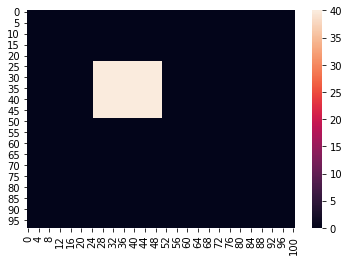

In [105]:
sns.heatmap(X0[1:101][1:101])

### Simulación

In [157]:
N_pasos = 10
a = np.zeros((4,101,101))
t = 0
for i in range(1,101):
    for j in range(1,101):
        a[0][i][j] = D*(X[i][j] - X[i - 1][j])
        if a[0][i][j] < 0:
            a[0][i][j] = 0
        a[1][i][j] = D*(X[i][j] - X[i + 1][j])
        if a[1][i][j] < 0:
            a[1][i][j] = 0
        a[2][i][j] = D*(X[i][j] - X[i][j - 1])
        if a[2][i][j] < 0:
            a[2][i][j] = 0
        a[3][i][j] = D*(X[i][j] - X[i - 1][j + 1])
        if a[3][i][j] < 0:
            a[3][i][j] = 0
tiempos = [0]

P2 = np.zeros((4,101,101))
P3 = np.zeros((4))
P4 = np.zeros((4,101))
P5 = np.zeros((4,101))

a0, P2, P3, P4, P5 = act_probs(a,P2,P3,P4,P5)


for i in range(0,N_pasos):
    t, X0, a0, a, P2, P3, P4, P5 = paso_montecarlo(X0, a, t, P2, P3, P4, P5)
    tiempos.append(t)
    sns.heatmap(X0[1:101][1:101])

IndexError: index 101 is out of bounds for axis 0 with size 101

In [117]:
r2 = np.random.rand()
suma_mu = 0
for nu in range(4):
    suma_mu = suma_mu + P3[nu]
    if suma_mu <= r2:
        mu = nu

In [118]:
mu

1

In [151]:
def funcion_pinata():
    r4 = np.random.rand()
    suma_j = 0
    for j_star in range(1,101):
        suma_j = suma_j + P5[mu][j_star]
        if suma_j >= r4*P5[mu][j_star]:
            j = j_star
    return j

In [152]:
funcion_pinata()

100